In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import kagglehub

# Download latest version
path = kagglehub.dataset_download("joniarroba/noshowappointments")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/noshowappointments


In [3]:
# Load the dataset from the specified path
try:
  df = pd.read_csv(path + '/KaggleV2-May-2016.csv')
  print(df.head())
except FileNotFoundError:
  print(f"Error: File not found at {path + '/KaggleV2-May-2016.csv'}. Please check the path.")
except Exception as e:
  print(f"An error occurred: {e}")

      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1         0           0        0      

In [4]:
# Data Description
print("\nFirst five rows:")
print(df.head())

print("\nShape: ")
print(df.shape)

print("\nDescription of the data:")
print(df.describe(include='all'))

# Drop missing values
missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)

df_cleaned = df.dropna(inplace=False)

print("\nShape of the dataframe after dropping rows with missing values:")
print(df_cleaned.shape)


First five rows:
      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1         0         

In [5]:
# Data Cleaning

# Make handcap binary (currently indicates number of handicaps but will now indicate whether there is a handicap or not)
df_cleaned['Handcap'] = (df_cleaned['Handcap'] > 0).astype(int)

# Convert 'No-show' to binary (Yes -> 1, No -> 0)
df_cleaned['No-show'] = df_cleaned['No-show'].map({'Yes': 1, 'No': 0})

# Ensuring no duplicated appointment ids
print(f' Number of duplicated PatientID: {sum(df_cleaned.PatientId.duplicated())}')
print(f' Number of duplicated AppointmentID: {sum(df_cleaned.AppointmentID.duplicated())}')

# Convert ids to string
df_cleaned.PatientId = df_cleaned.PatientId.astype('int64').astype(str)
df_cleaned.AppointmentID = df_cleaned.AppointmentID.astype(str)

# Convert 'ScheduledDay' and 'AppointmentDay' to datetime format and keep only the date (no timestamps bc they cause negative values in waiting days column)
df_cleaned['ScheduledDay'] = pd.to_datetime(df_cleaned['ScheduledDay']).dt.strftime('%Y-%m-%d')
df_cleaned['AppointmentDay'] = pd.to_datetime(df_cleaned['AppointmentDay']).dt.strftime('%Y-%m-%d')

# Checking unique values
columns1 = ['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']
for col in columns1:
    print(f"\nUnique values in {col}:")
    print(df_cleaned[col].value_counts()) #Handcap indicates number of handicaps so ok to not be binary

# Fixing negative ages
print(f'Number of rows with negative age: {sum(df_cleaned.Age < 0)}')
df_cleaned.drop(df_cleaned[df_cleaned.Age < 0].index, inplace=True)

 Number of duplicated PatientID: 48228
 Number of duplicated AppointmentID: 0

Unique values in Gender:
Gender
F    71840
M    38687
Name: count, dtype: int64

Unique values in Age:
Age
 0      3539
 1      2273
 52     1746
 49     1652
 53     1651
        ... 
 115       5
 100       4
 102       2
 99        1
-1         1
Name: count, Length: 104, dtype: int64

Unique values in Scholarship:
Scholarship
0    99666
1    10861
Name: count, dtype: int64

Unique values in Hipertension:
Hipertension
0    88726
1    21801
Name: count, dtype: int64

Unique values in Diabetes:
Diabetes
0    102584
1      7943
Name: count, dtype: int64

Unique values in Alcoholism:
Alcoholism
0    107167
1      3360
Name: count, dtype: int64

Unique values in Handcap:
Handcap
0    108286
1      2241
Name: count, dtype: int64

Unique values in SMS_received:
SMS_received
0    75045
1    35482
Name: count, dtype: int64

Unique values in No-show:
No-show
0    88208
1    22319
Name: count, dtype: int64
Number of

In [6]:
# Feature Engineering

#Create New Features
df_cleaned['WaitingDays'] = (pd.to_datetime(df_cleaned['AppointmentDay']) - pd.to_datetime(df_cleaned['ScheduledDay'])).dt.days
df_cleaned['AppointmentWeekday'] = pd.to_datetime(df_cleaned['AppointmentDay']).dt.day_name()
df_cleaned['ScheduledWeekday'] = pd.to_datetime(df_cleaned['ScheduledDay']).dt.day_name()

#df_cleaned['AppointmentMonth'] = pd.to_datetime(df_cleaned['AppointmentDay']).dt.month
#def get_weather_pattern(month):
    #if month in [1, 2, 3, 10, 11, 12]:
        #return 'Rainy'
    #else:
        #return 'Dry'
#df_cleaned['WeatherPattern'] = df_cleaned['AppointmentMonth'].apply(get_weather_pattern)

print(df_cleaned.head())

# Checking unique values
columns2 = ['WaitingDays', 'AppointmentWeekday', 'ScheduledWeekday']
for col in columns2:
    print(f"\nUnique values in {col}:")
    print(df_cleaned[col].value_counts())

# Get rid of any rows where WaitingDays is less than 0
negative_waitingdays_count = (df_cleaned['WaitingDays'] < 0).sum()
print(f"Number of rows with WaitingDays < 0: {negative_waitingdays_count}")
df_cleaned = df_cleaned[df_cleaned['WaitingDays'] >= 0]
print(df_cleaned.shape)

# Create features and label groups
label_column = 'No-show'
features = df_cleaned.drop(columns=[label_column])
label = df_cleaned[label_column]

print("\nFeatures:")
print(features.head())

print("\nLabel:")
print(label.head())

         PatientId AppointmentID Gender ScheduledDay AppointmentDay  Age  \
0   29872499824296       5642903      F   2016-04-29     2016-04-29   62   
1  558997776694438       5642503      M   2016-04-29     2016-04-29   56   
2    4262962299951       5642549      F   2016-04-29     2016-04-29   62   
3     867951213174       5642828      F   2016-04-29     2016-04-29    8   
4    8841186448183       5642494      F   2016-04-29     2016-04-29   56   

       Neighbourhood  Scholarship  Hipertension  Diabetes  Alcoholism  \
0    JARDIM DA PENHA            0             1         0           0   
1    JARDIM DA PENHA            0             0         0           0   
2      MATA DA PRAIA            0             0         0           0   
3  PONTAL DE CAMBURI            0             0         0           0   
4    JARDIM DA PENHA            0             1         1           0   

   Handcap  SMS_received  No-show  WaitingDays AppointmentWeekday  \
0        0             0        0  

<ipython-input-7-4e5f3160328a>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No', 'Yes'])
<ipython-input-7-4e5f3160328a>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No', 'Yes'])
<ipython-input-7-4e5f3160328a>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No', 'Yes'])
<ipython-input-7-4e5f3160328a>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No', 'Yes'])
<ipython-input-7-4e5f3160328a>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No', 'Yes'])


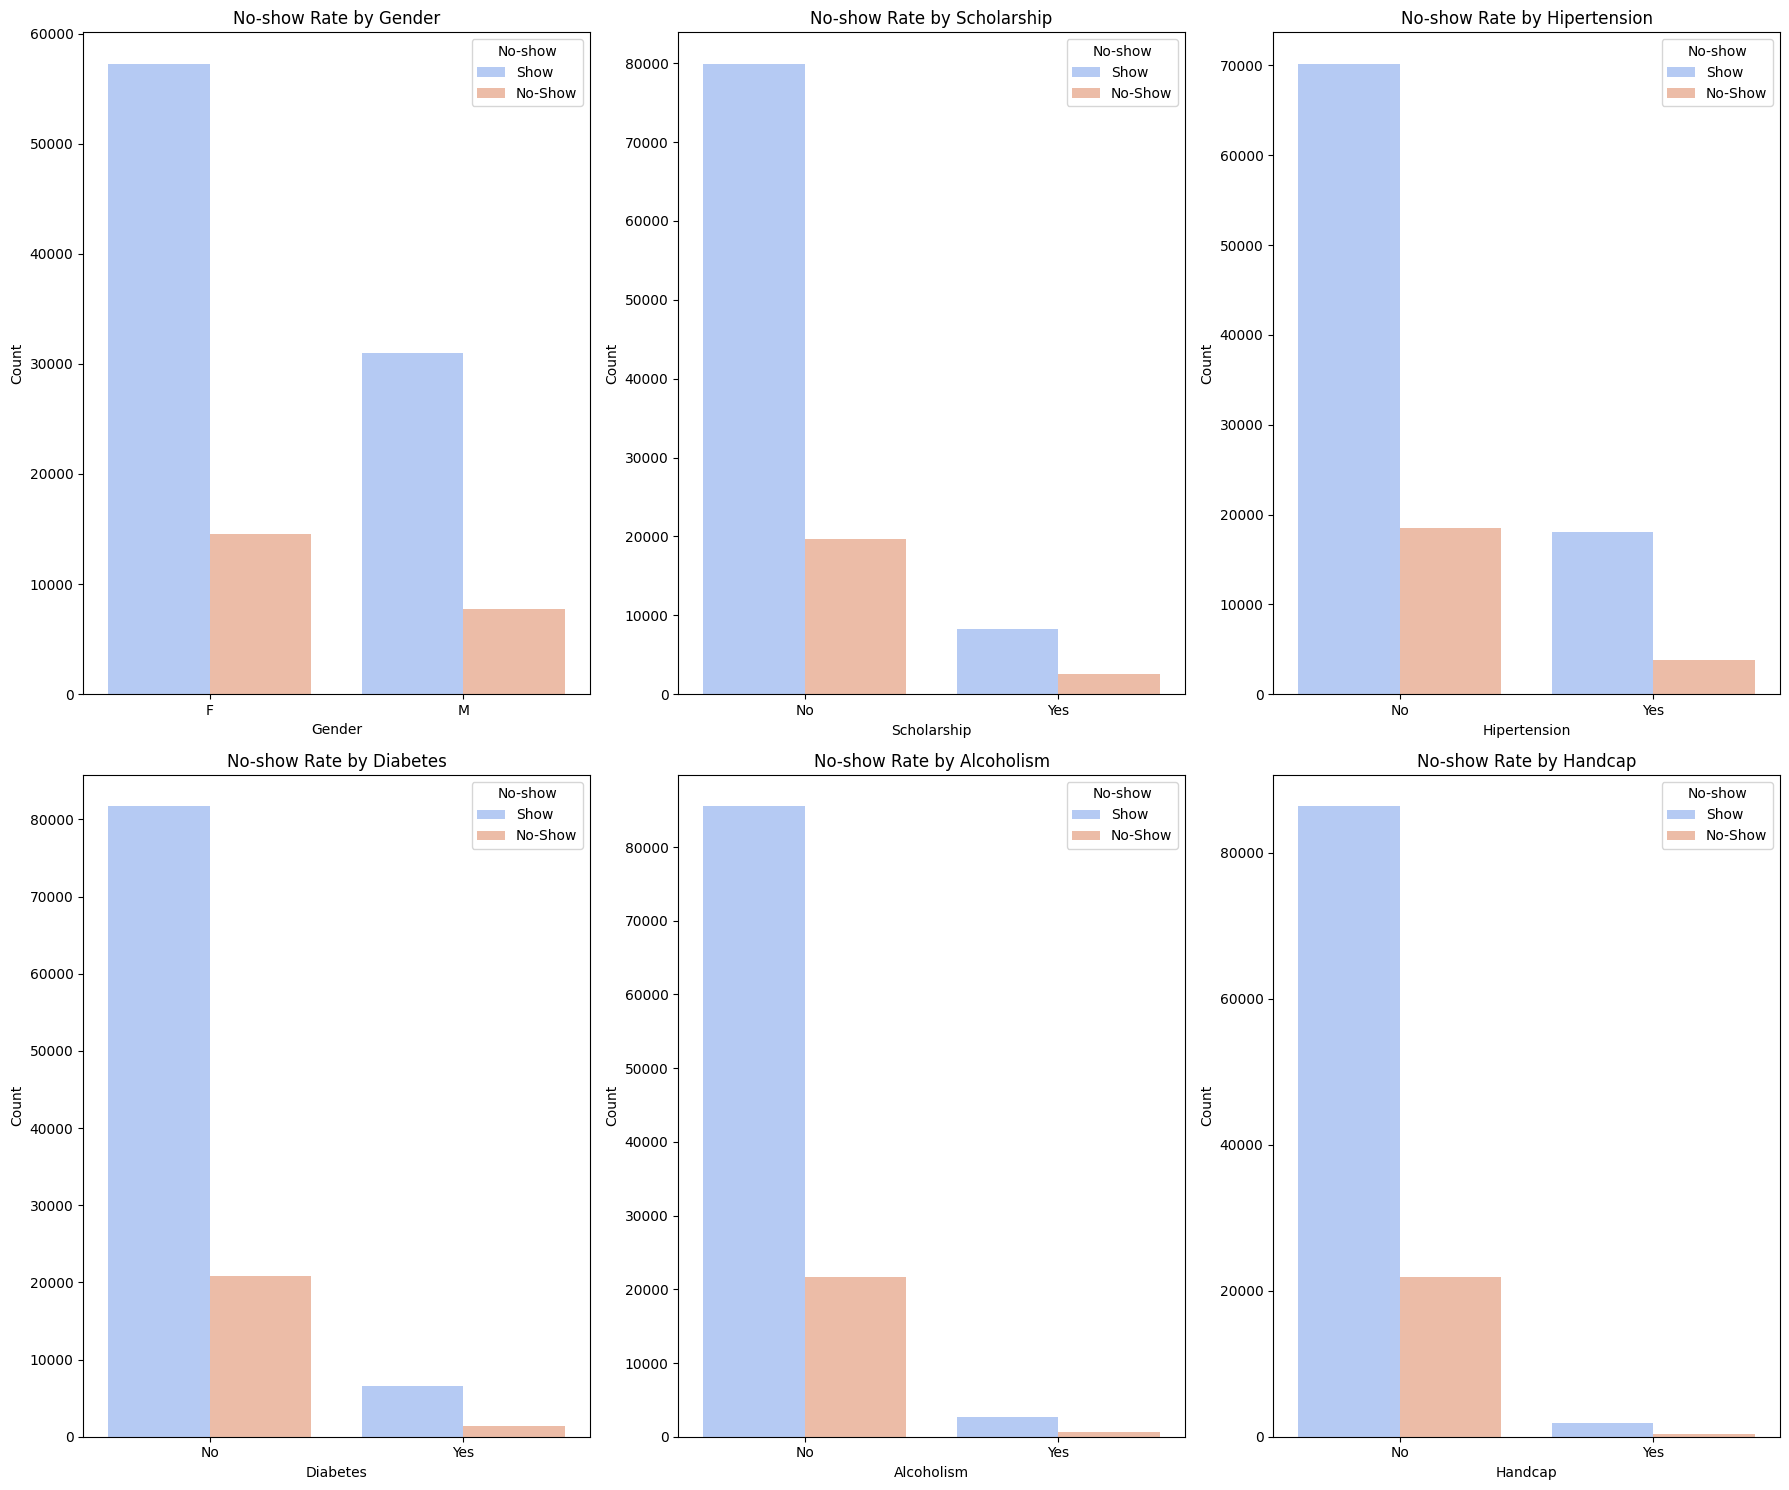

In [7]:
# Exploratory Data Analysis

# No-show Rate Analysis (categorical demographic vars)
# Define categorical variables
categorical_vars = ['Gender', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap']

# Create subplots for No-show rate by categorical variables
fig, axes = plt.subplots(2, 3, figsize=(18, 15))

for ax, var in zip(axes.flat, categorical_vars):
    sns.countplot(x=var, hue='No-show', data=df_cleaned, ax=ax, palette="coolwarm")
    ax.legend(title='No-show', labels=['Show', 'No-Show'])
    ax.set_title(f'No-show Rate by {var}')
    ax.set_xlabel(var)
    if var in ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']:
        ax.set_xticklabels(['No', 'Yes'])
    ax.set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

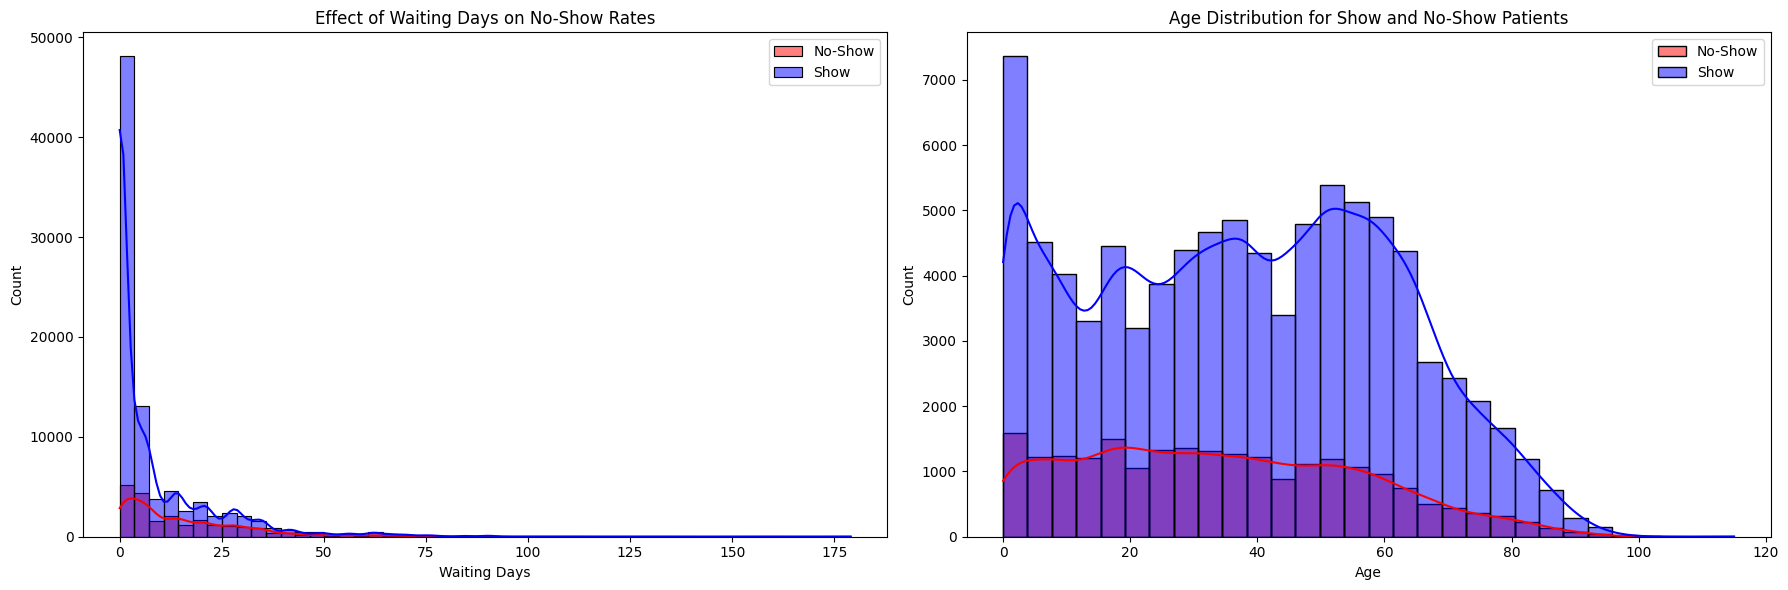

In [8]:
# No-show Rate Analysis (continuous vars)
g, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot WaitingDays distribution for No-show vs Show
sns.histplot(df_cleaned[df_cleaned['No-show'] == 1]['WaitingDays'], bins=50, kde=True, color='red', label="No-Show", ax=axes[0])
sns.histplot(df_cleaned[df_cleaned['No-show'] == 0]['WaitingDays'], bins=50, kde=True, color='blue', label="Show", ax=axes[0])
axes[0].legend()
axes[0].set_title('Effect of Waiting Days on No-Show Rates')
axes[0].set_xlabel('Waiting Days')
axes[0].set_ylabel('Count')

# Plot Age distribution for No-show vs Show
sns.histplot(df_cleaned[df_cleaned['No-show'] == 1]['Age'], bins=30, kde=True, color='red', label="No-Show", ax=axes[1])
sns.histplot(df_cleaned[df_cleaned['No-show'] == 0]['Age'], bins=30, kde=True, color='blue', label="Show", ax=axes[1])
axes[1].legend()
axes[1].set_title('Age Distribution for Show and No-Show Patients')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

<ipython-input-9-501735d5a648>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_noshow_rates.index, y=weekday_noshow_rates.values, palette="coolwarm", ax=axes[0])
<ipython-input-9-501735d5a648>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(weekday_noshow_rates.index, rotation=45)
<ipython-input-9-501735d5a648>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sms_noshow_rates.index, y=sms_noshow_rates.values, palette="coolwarm", ax=axes[1])
<ipython-input-9-501735d5a648>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set

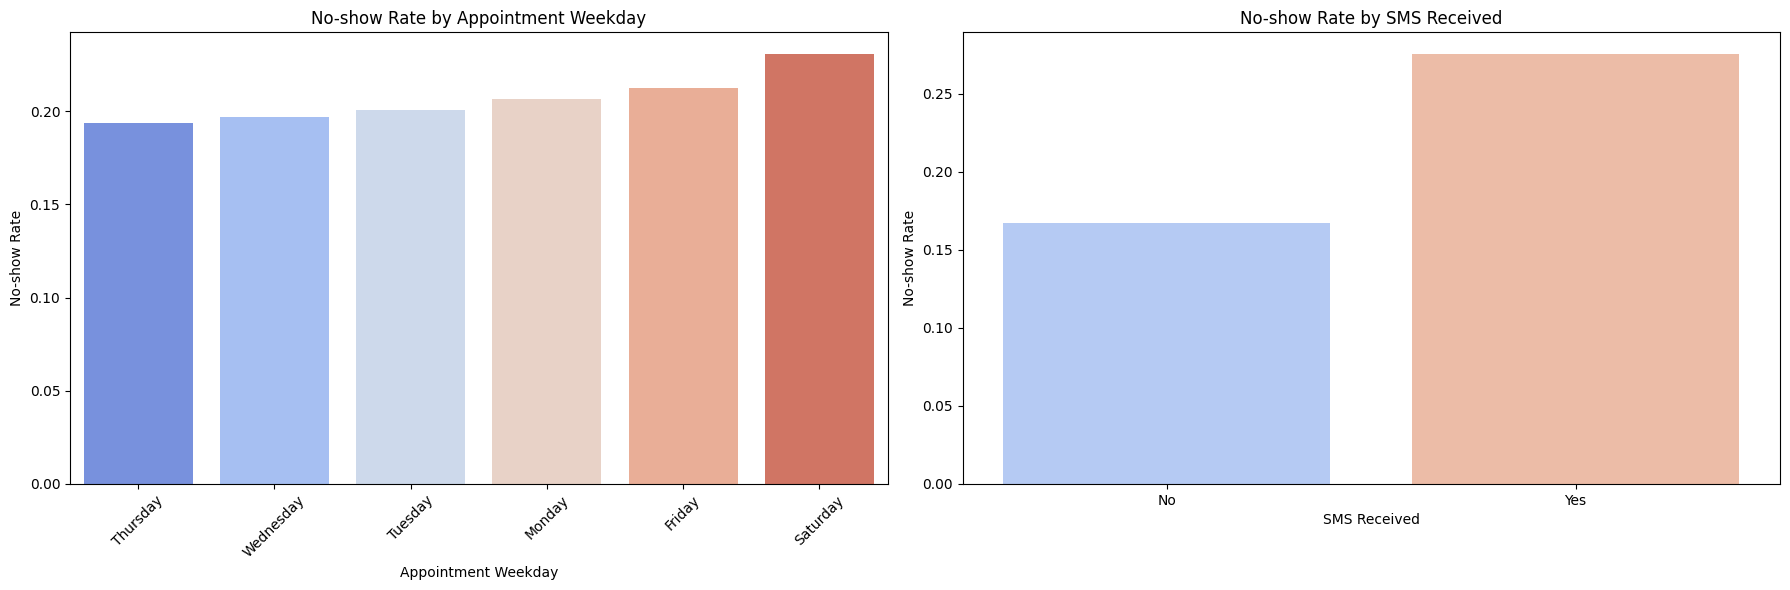

In [9]:
# No-Show Rate Analysis (sms, weekday, and weather)
g, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot No-show Rate by Appointment Weekday
weekday_noshow_rates = df_cleaned.groupby('AppointmentWeekday')['No-show'].mean().sort_values()
sns.barplot(x=weekday_noshow_rates.index, y=weekday_noshow_rates.values, palette="coolwarm", ax=axes[0])
axes[0].set_title("No-show Rate by Appointment Weekday")
axes[0].set_xlabel("Appointment Weekday")
axes[0].set_ylabel("No-show Rate")
axes[0].set_xticklabels(weekday_noshow_rates.index, rotation=45)

# Plot No-show Rate by SMS Received
sms_noshow_rates = df_cleaned.groupby('SMS_received')['No-show'].mean()
sns.barplot(x=sms_noshow_rates.index, y=sms_noshow_rates.values, palette="coolwarm", ax=axes[1])
axes[1].set_title("No-show Rate by SMS Received")
axes[1].set_xlabel("SMS Received")
axes[1].set_ylabel("No-show Rate")
axes[1].set_xticklabels(["No", "Yes"])  # Replace 0/1 with No/Yes labels

# Adjust layout
plt.tight_layout()
plt.show()

# Plot No-show Rate by Weather Pattern
#does not make sense to do as all data points are in dry season
#print(df_cleaned['WeatherPattern'].value_counts())
#weather pattern and month variables will be discarded

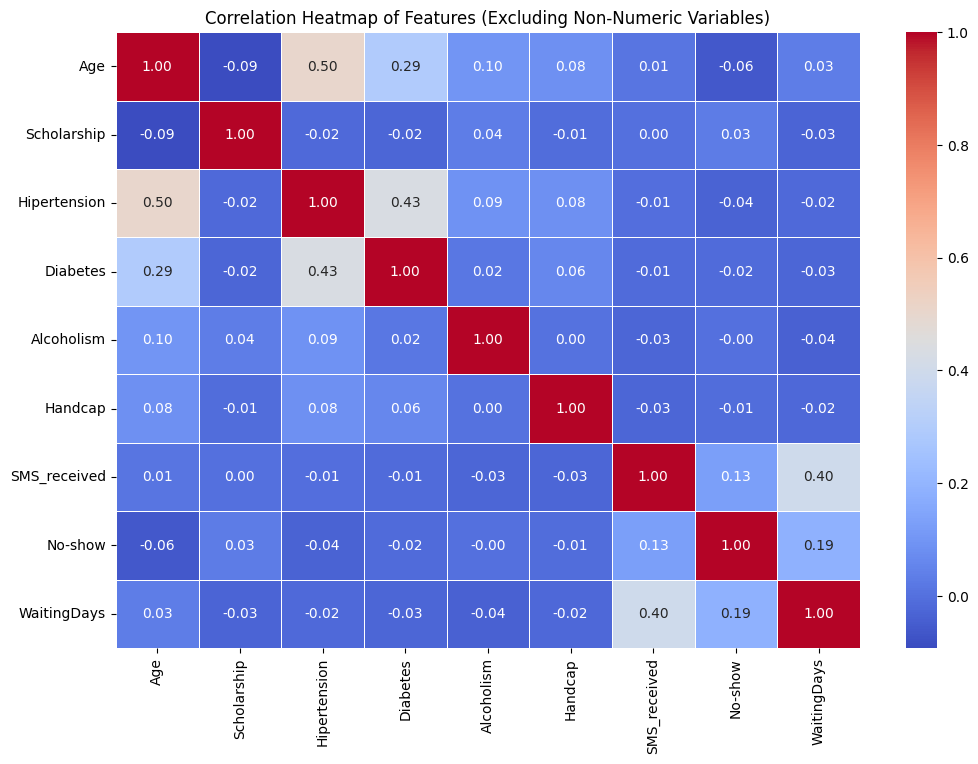


Top Correlations with No-show:
 No-show         1.000000
WaitingDays     0.186320
SMS_received    0.126502
Scholarship     0.029166
Alcoholism     -0.000181
Handcap        -0.007528
Diabetes       -0.015158
Hipertension   -0.035662
Age            -0.060320
Name: No-show, dtype: float64


In [10]:
# Correlation Heatmap Analysis
numerical_features = df_cleaned.select_dtypes(include=['number'])  # Select only numeric columns

# Compute correlation matrix without categorical variables
correlation_matrix_filtered = numerical_features.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_filtered, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Features (Excluding Non-Numeric Variables)")
plt.show()

# Display top correlations with No-show
no_show_correlation_filtered = correlation_matrix_filtered['No-show'].sort_values(ascending=False)
print("\nTop Correlations with No-show:\n", no_show_correlation_filtered)

<ipython-input-11-c00b830eb2ce>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["No", "Yes"])


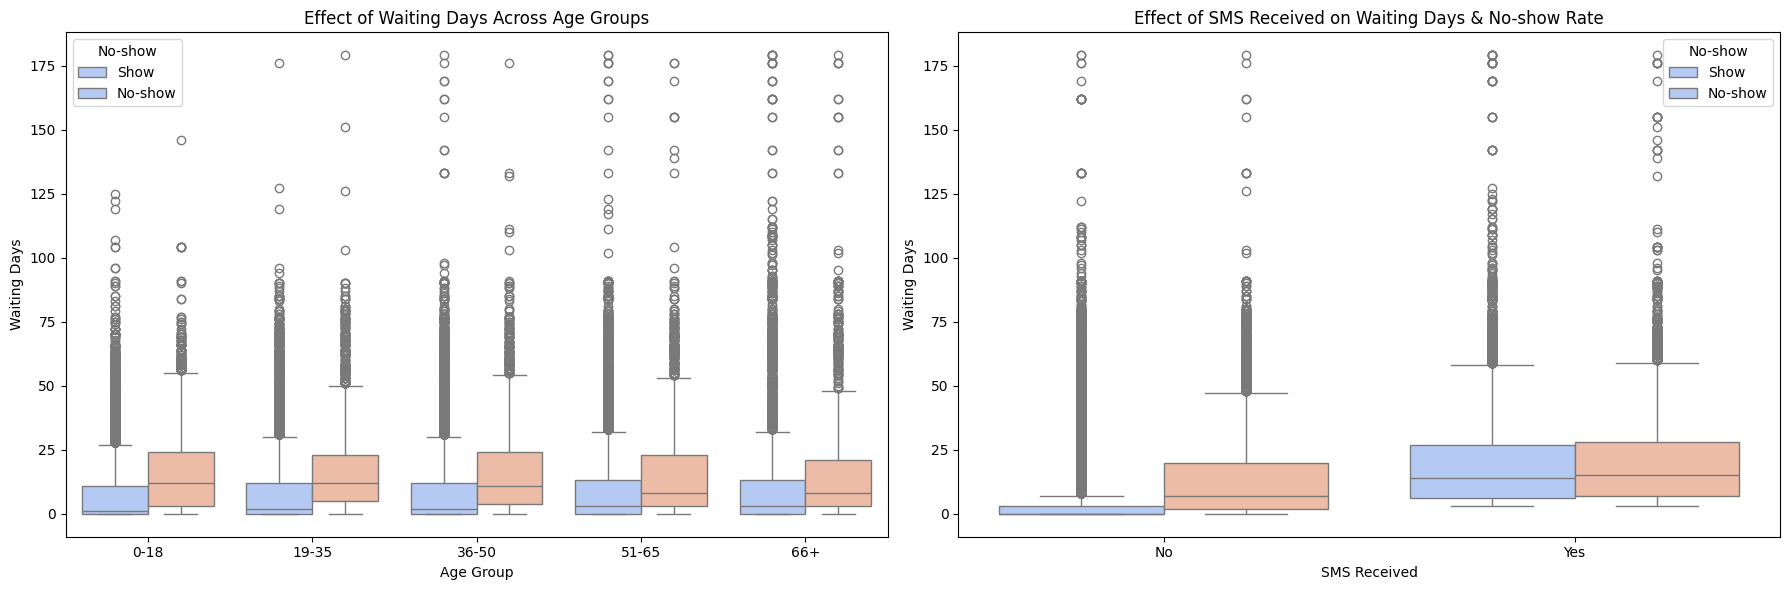

In [11]:
# Variable Interaction Analysis
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Define age groups for better visualization
df_cleaned['AgeGroup'] = pd.cut(df_cleaned['Age'], bins=[0, 18, 35, 50, 65, 100],
                                labels=['0-18', '19-35', '36-50', '51-65', '66+'])

# Interaction Between WaitingDays and Age Groups on No-show Rate
sns.boxplot(x='AgeGroup', y='WaitingDays', hue='No-show', data=df_cleaned, ax=axes[0], palette="coolwarm")
axes[0].set_title("Effect of Waiting Days Across Age Groups")
axes[0].set_xlabel("Age Group")
axes[0].set_ylabel("Waiting Days")
axes[0].legend(title="No-show", labels=["Show", "No-show"])

# Interaction Between SMS Received and WaitingDays on No-show Rate
sns.boxplot(x='SMS_received', y='WaitingDays', hue='No-show', data=df_cleaned, ax=axes[1], palette="coolwarm")
axes[1].set_title("Effect of SMS Received on Waiting Days & No-show Rate")
axes[1].set_xlabel("SMS Received")
axes[1].set_xticklabels(["No", "Yes"])
axes[1].set_ylabel("Waiting Days")
axes[1].legend(title="No-show", labels=["Show", "No-show"])

# Adjust layout
plt.tight_layout()
plt.show()


In [12]:
# Statistical Modeling Prep

# Select Variables for Modeling
print(df_cleaned.head())

X = df_cleaned.drop(columns=[
    'No-show',           # target
    'PatientId',         # ID
    'AppointmentID',     # ID
    'ScheduledDay',      # raw date
    'AppointmentDay',     # raw date
    'AgeGroup'           # unnecesary with age variable
])
y = df_cleaned['No-show']

# One Hot Encode
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['Gender', 'Neighbourhood', 'AppointmentWeekday', 'ScheduledWeekday']
encoder = OneHotEncoder(drop=None, handle_unknown='ignore', sparse_output=False)
encoded_array = encoder.fit_transform(X[categorical_cols])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=X.index)
X_encoded = pd.concat([X.drop(columns=categorical_cols), encoded_df], axis=1)
print(X_encoded.head())

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)

         PatientId AppointmentID Gender ScheduledDay AppointmentDay  Age  \
0   29872499824296       5642903      F   2016-04-29     2016-04-29   62   
1  558997776694438       5642503      M   2016-04-29     2016-04-29   56   
2    4262962299951       5642549      F   2016-04-29     2016-04-29   62   
3     867951213174       5642828      F   2016-04-29     2016-04-29    8   
4    8841186448183       5642494      F   2016-04-29     2016-04-29   56   

       Neighbourhood  Scholarship  Hipertension  Diabetes  Alcoholism  \
0    JARDIM DA PENHA            0             1         0           0   
1    JARDIM DA PENHA            0             0         0           0   
2      MATA DA PRAIA            0             0         0           0   
3  PONTAL DE CAMBURI            0             0         0           0   
4    JARDIM DA PENHA            0             1         1           0   

   Handcap  SMS_received  No-show  WaitingDays AppointmentWeekday  \
0        0             0        0  

In [13]:
# Modeling and Evaluation

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Helper function to train and evaluate a model
def train_and_evaluate(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n=== {model_name} ===")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    return model

# Decision Tree
tree_model = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
train_and_evaluate(tree_model, "Decision Tree")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)
train_and_evaluate(rf_model, "Random Forest")

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1, random_state=42)
train_and_evaluate(xgb_model, "XGBoost")


=== Decision Tree ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9233    0.5064    0.6540     26463
           1     0.2993    0.8337    0.4405      6694

    accuracy                         0.5725     33157
   macro avg     0.6113    0.6700    0.5473     33157
weighted avg     0.7973    0.5725    0.6109     33157

ROC AUC Score: 0.7222817070123592
Confusion Matrix:
[[13400 13063]
 [ 1113  5581]]

=== Random Forest ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9340    0.4745    0.6293     26463
           1     0.2946    0.8675    0.4398      6694

    accuracy                         0.5539     33157
   macro avg     0.6143    0.6710    0.5346     33157
weighted avg     0.8049    0.5539    0.5911     33157

ROC AUC Score: 0.7235740616854865
Confusion Matrix:
[[12558 13905]
 [  887  5807]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:13:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost ===
Classification Report:
              precision    recall  f1-score   support

           0     0.8072    0.9835    0.8867     26463
           1     0.5225    0.0713    0.1254      6694

    accuracy                         0.7993     33157
   macro avg     0.6648    0.5274    0.5060     33157
weighted avg     0.7497    0.7993    0.7330     33157

ROC AUC Score: 0.7398031098231295
Confusion Matrix:
[[26027   436]
 [ 6217   477]]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [14]:
# SHAP Analysis

import shap

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, max_display=15)
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=15)

# SHAP Dependence Plot for Age
shap.dependence_plot(
    "Age", shap_values.values, X_train, show=True
)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [16]:
# Bayesian Causal Forest
#!pip install econml
#!pip install causalml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: shap
    Found existing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.1 MB/s eta 0:00:00


In [16]:
from econml.grf import CausalForest

# Define outcome, treatment, and covariates
Y = df_cleaned['No-show'].values  # outcome: no-show or show
T = df_cleaned['SMS_received'].values  # treatment: received SMS or not
X_cf = df_cleaned.drop(columns=[
    'PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay',
    'No-show', 'SMS_received', 'AgeGroup'
]) # covariates: all other variables dropping no show, sms, and irrelevant variables

# One-hot encode the categorical features
X_cf_encoded = pd.get_dummies(X_cf, drop_first=True)

# Model
causal_forest = CausalForest()
causal_forest.fit(X_cf_encoded, T, Y)

# Estimate CATEs (individual treatment effects)
cate_preds = causal_forest.predict(X_cf_encoded)

# Estimate average treatment effect (ATE)
ate = np.mean(cate_preds)
print(f"Estimated Average Treatment Effect (ATE) of SMS on No-show: {ate:.4f}")

Estimated Average Treatment Effect (ATE) of SMS on No-show: -0.0298


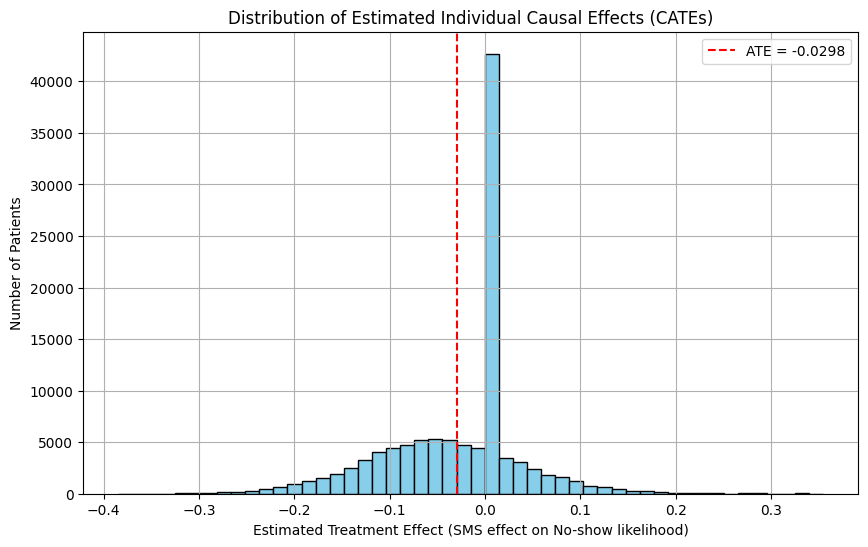

In [17]:
# Plot Histogram of Individual CATEs
plt.figure(figsize=(10, 6))
plt.hist(cate_preds, bins=50, color='skyblue', edgecolor='black')
plt.axvline(np.mean(cate_preds), color='red', linestyle='--', label=f'ATE = {ate:.4f}')
plt.title("Distribution of Estimated Individual Causal Effects (CATEs)")
plt.xlabel("Estimated Treatment Effect (SMS effect on No-show likelihood)")
plt.ylabel("Number of Patients")
plt.legend()
plt.grid(True)
plt.show()